In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import random
from tqdm.notebook import tqdm
from math import sin, cos, sqrt, atan2, radians

from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)

In [2]:
# Set the size bins
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,330]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['impact_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

,high,low,lambda_start,lambda_end,impact_factor
005,16950000,1695000,1.0,2,0.1
005-009,855000,85500,1.1,4,0.2
010-050,146100,14610,1.2,8,0.3
050-100,8700,870,1.4,16,0.6
100+,3050,305,1.8,32,0.8


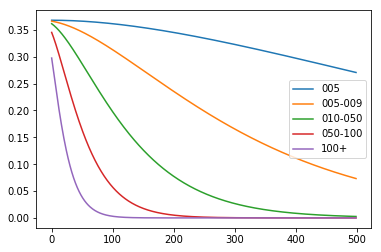

total impacts 2251516.0
impacts by diameter {'005': 1929108.0, '005-009': 187552.0, '010-050': 131150.0, '050-100': 3377.0, '100+': 329.0}
fraction of total {'005': 0.86, '005-009': 0.08, '010-050': 0.06, '050-100': 0.0, '100+': 0.0}


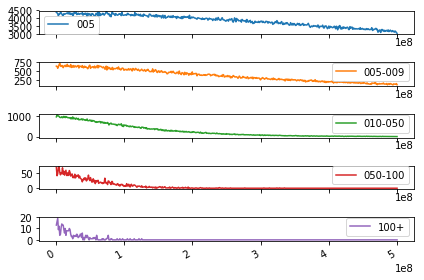

,high,low,lambda_start,lambda_end,impact_factor,total
005,16950000,1695000,1.0,2,0.000086,1929108.0
005-009,855000,85500,1.1,4,0.000557,187552.0
010-050,146100,14610,1.2,8,0.000370,131150.0
050-100,8700,870,1.4,16,0.006338,3377.0
100+,3050,305,1.8,32,0.022547,329.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'impact_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [6]:
class IMPAaCS:
    
    #####      Input parameters (Read from Config file)      #############################
    count_test_hits = 0
    impact_test_id = str(round(-87.5726,4))+' '+str(round(33.2921,4))
    grid_cell_state = {}
    impacted_grid_cells = []
    impactors_at_test_cell = [0]
    test_time = [0]
    
    def __init__(self, egrid, 
                 primitive_initial_state=45,
                 fraction_upper_layer = 2/3,
                 target_SiO2 = 62.58,     # From sudbury
                 upper_SiO2 = 68.71,      # From sudbury
                 n_layers_impact_melt = 2,
                 z_discretized_km = int(2),
                 proportion_melt_from_impact = 1/3):
        self.egrid = egrid
        self.primitive_initial_state = primitive_initial_state
        self.fraction_upper_layer = fraction_upper_layer        # d_upper / Mi (from Sudbury)
        self.fraction_lower_layer = 1-self.fraction_upper_layer # d_lower / Mi (from Sudbury)
        self.n_layers_impact_melt = n_layers_impact_melt
        self.target_SiO2 = target_SiO2 # From sudbury
        self.upper_SiO2 = upper_SiO2  # From sudbury
        self.z_discretized_km = z_discretized_km
        self.proportion_melt_from_impact = proportion_melt_from_impact
        self.average_target = self.primitive_initial_state
        self.average_target_list = [self.primitive_initial_state]
        self.top_layer_at_test_cell = [self.primitive_initial_state]
        self.average_test_target_list = [self.primitive_initial_state]

    #--------------------------------------------------------------------------------------------------
    def update(self, impact_loc, impactor_diameter):
        self.impact_dimensions(impactor_diameter)
        self.find_the_grid(impact_loc)
        self.get_average_target(impactor_diameter)
        self.loop_impact_grid(impactor_diameter)
        
    #--------------------------------------------------------------------------------------------------
    #---- THIS IS THE MAIN CODE -------------------- THIS IS THE MAIN CODE ----------------------------
    #--------------------------------------------------------------------------------------------------
    def state_dynamics(self, impactor_diameter, grid_cell_id):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """
        
        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * self.proportion_melt_from_impact # D/3

        #Vertical discretization.
        melt_layers = int(depth_of_impact_melt / self.z_discretized_km)

        lower_layer  = range(int(round(self.fraction_upper_layer * melt_layers,2)), melt_layers)
        upper_layer  = range(0, int(round(self.fraction_upper_layer * melt_layers,2)))

        fracionated_melt = depth_of_impact_melt * self.fraction_upper_layer #Units: km

        fractionation_factor = 1 - (self.target_SiO2 / self.upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in lower_layer:
            self.grid_cell_state[grid_cell_id][i] = self.primitive_initial_state

        # Impact melt portion  (Upper)
        for i in upper_layer:
            self.grid_cell_state[grid_cell_id][i] = self.average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = self.grid_cell_state[grid_cell_id][0]

        # Lower of impact melt portion
        for i in lower_layer:
            numerator = self.average_target-(self.fraction_upper_layer * wt_sio2_upper)
            self.grid_cell_state[grid_cell_id][i] = numerator / self.fraction_lower_layer

        for i in range(melt_layers):
            self.grid_cell_state[grid_cell_id][i] = np.round(self.grid_cell_state[grid_cell_id][i],1)
    
    #--------------------------------------------------------------------------------------------------    
    def state_prep(self, grid_cell_id, impactor_diameter):

        ##### Set the initial state values
        if grid_cell_id not in self.grid_cell_state.keys():
            self.grid_cell_state[grid_cell_id] = np.ones(self.z_layers) * self.primitive_initial_state
        else: # If there is an existing state key, 
              # and the current impact depth is larger than the z layers, 
              # then extend the z layers
            existing_z_layers = self.grid_cell_state[grid_cell_id].shape[0]
            if self.z_layers > existing_z_layers:
                self.grid_cell_state[grid_cell_id] = np.append(grid_cell_state[grid_cell_id], 
                                            np.ones(z_layers - existing_z_layers) * self.primitive_initial_state)
    
    #--------------------------------------------------------------------------------------------------    
    def get_average_target(self, impactor_diameter):
        average_target = 0
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
            ### If the grid cell has not been hit yet, it is the initial primitive value
            if grid_cell_id in self.grid_cell_state.keys():
                average_target += np.sum(self.grid_cell_state[grid_cell_id][:self.z_layers])
            else:
                average_target += self.primitive_initial_state * self.z_layers
        self.average_target = average_target/(len(self.impacted_grid_cells) * self.z_layers)
        
    #--------------------------------------------------------------------------------------------------    
    def find_the_grid(self, impact_loc):
        self.impacted_grid_cells = [] # first reset the impacted grid cells, then fill them up
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                if D < self.crator_radius:
                    self.impacted_grid_cells.append([ilon, ilat])

    #--------------------------------------------------------------------------------------------------    
    def loop_impact_grid(self, impactor_diameter):
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

            ##### Set the initial state values
            self.state_prep(grid_cell_id, impactor_diameter)

            ################      DO THE DYANMICS       #############################
            self.state_dynamics(impactor_diameter, grid_cell_id)

            self.test_one_grid_cell(grid_cell_id, impactor_diameter)
    #--------------------------------------------------------------------------------------------------    
    def impact_dimensions(self, impactor_diameter):
            # The impact crator is 10*Diameter, so the radius is half that
            self.crator_diameter = 10*impactor_diameter
            self.crator_radius = self.crator_diameter/2
            self.z_layers = int(np.ceil(impactor_diameter / self.z_discretized_km))

    #--------------------------------------------------------------------------------------------------    
    def test_one_grid_cell(self, grid_cell_id, impactor_diameter):
        ##### Testing one cell:
        if grid_cell_id == self.impact_test_id:
            self.count_test_hits+=1
            self.test_time.append(t+1000000)
            self.impactors_at_test_cell.append(impactor_diameter)
            self.average_test_target_list.append(self.average_target)
            self.top_layer_at_test_cell.append(self.grid_cell_state[self.impact_test_id][0])

In [7]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

This is only a test. I am forcing impacts at one location to test the dynamics
This is only a test. I am forcing impacts at one location to test the dynamics
time 0
This is only a test. I am forcing impacts at one location to test the dynamics
330 diameter IMPAaC at Test cell: -87.5726 33.2921
average_target: 45.0, across 6541 grid cells
SiO2 states:
[49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
 
time 1
This is only a test. I am forcing impacts at one location to test the dynamics
73 diameter IMPAaC at Test cell: -87.5726 33.2921
average_target: 49.0, across 323 grid cells
SiO2 states:
[

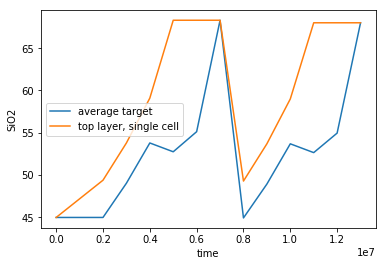

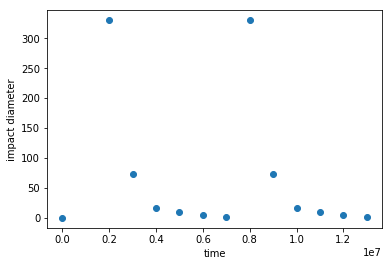

In [8]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()